In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from collections import OrderedDict
from PIL import Image

# # Loading data

In [2]:
data_dir = './images'

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=8)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
print(class_names)

['Arts & Photography', 'Biographies & Memoirs', 'Business & Money', 'Calendars', "Children's Books", 'Christian Books & Bibles', 'Comics & Graphic Novels', 'Computers & Technology', 'Cookbooks, Food & Wine', 'Crafts, Hobbies & Home', 'Engineering & Transportation', 'Health, Fitness & Dieting', 'History', 'Humor & Entertainment', 'Law', 'Literature & Fiction', 'Medical Books', 'Mystery, Thriller & Suspense', 'Parenting & Relationships', 'Politics & Social Sciences', 'Reference', 'Religion & Spirituality', 'Romance', 'Science & Math', 'Science Fiction & Fantasy', 'Self-Help', 'Sports & Outdoors', 'Teen & Young Adult', 'Test Preparation', 'Travel']


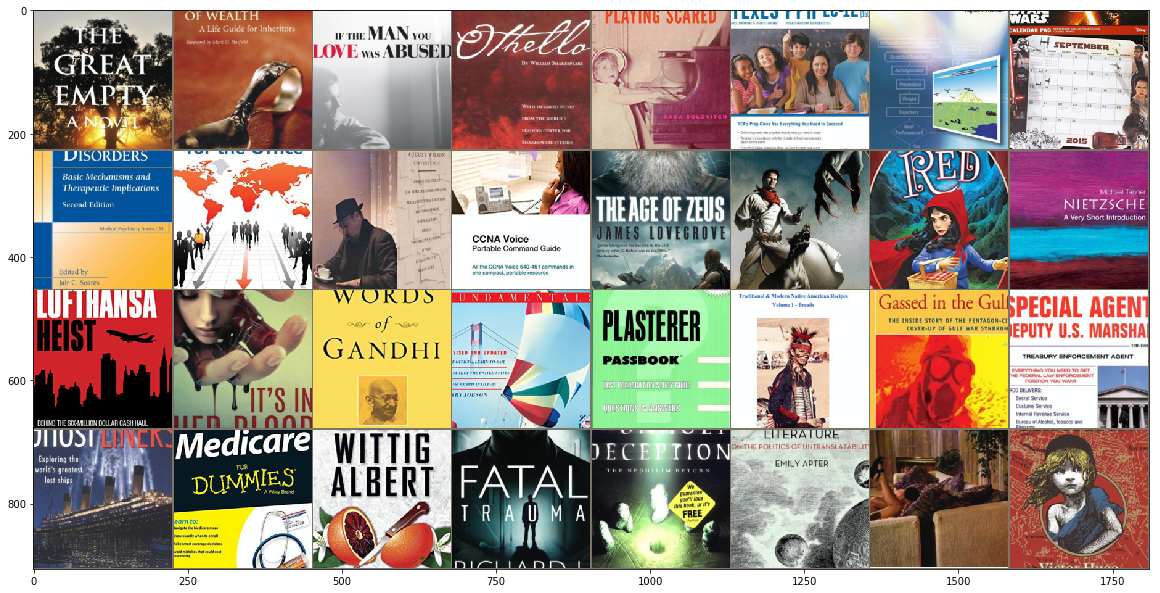

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=[20,20])
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
# inputs contains 4 images because batch_size=4 for the dataloaders
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
torchvision.utils.save_image(out, 'Covers.pdf')


imshow(out)

# # Training

In [4]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval() 

            running_loss = 0.0
            running_corrects = 0

            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                
                optimizer.zero_grad()

               
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()


                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

           
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))


    model.load_state_dict(best_model_wts)
    return model

In [12]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 30)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
optimizer = optim.Adam(model_ft.parameters(), lr = 0.001)

In [5]:
modelCNN = train_model(model_ft, criterion, optimizer,
                       num_epochs=25)
torch.save(modelCNN.state_dict(), 'CNN_model_april.pth') 

Epoch 0/24
----------
tensor(0.2049, device='cuda:0', dtype=torch.float64)
train Loss: 2.8639 Acc: 0.2049
tensor(0.2539, device='cuda:0', dtype=torch.float64)
val Loss: 2.6546 Acc: 0.2539

Epoch 1/24
----------
tensor(0.2511, device='cuda:0', dtype=torch.float64)
train Loss: 2.6714 Acc: 0.2511
tensor(0.2729, device='cuda:0', dtype=torch.float64)
val Loss: 2.6130 Acc: 0.2729

Epoch 2/24
----------
tensor(0.2697, device='cuda:0', dtype=torch.float64)
train Loss: 2.5893 Acc: 0.2697
tensor(0.2776, device='cuda:0', dtype=torch.float64)
val Loss: 2.6090 Acc: 0.2776

Epoch 3/24
----------
tensor(0.2882, device='cuda:0', dtype=torch.float64)
train Loss: 2.5260 Acc: 0.2882
tensor(0.2889, device='cuda:0', dtype=torch.float64)
val Loss: 2.5485 Acc: 0.2889

Epoch 4/24
----------
tensor(0.3004, device='cuda:0', dtype=torch.float64)
train Loss: 2.4679 Acc: 0.3004
tensor(0.2915, device='cuda:0', dtype=torch.float64)
val Loss: 2.5547 Acc: 0.2915

Epoch 5/24
----------
tensor(0.3172, device='cuda:0', d

In [ ]:
torch.save(modelCNN.state_dict(), 'CNN_model_april.pth') 

# # Testing

In [3]:
# Function to test the model 
from sklearn.metrics import confusion_matrix
import seaborn as sn

def test(): 
    # Load the model that we saved at the end of the training loop 
    y_pred = []
    y_true = []
     
    running_accuracy = 0 
    total = 0 
    correct = 0
 
    with torch.no_grad(): 
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)         
            
            outputs = model_ft(inputs)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.data.cpu().numpy())
            y_true.extend(labels.data.cpu().numpy())
            
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            accuracy = 100 * correct / total
            
            #print(preds,label)
            print(accuracy)
            running_accuracy += (preds == labels).sum().item() 
            #print(running_accuracy)
 
        print('Accuracy of the model','inputs is: %d %%' % (100 * running_accuracy / total))    
   
    # constant for classes
    classes = ('Arts & Photography', 'Biographies & Memoirs', 'Business & Money', 'Calendars', "Children's Books", 'Christian Books & Bibles', 'Comics & Graphic Novels', 'Computers & Technology', 'Cookbooks, Food & Wine', 'Crafts, Hobbies & Home', 'Engineering & Transportation', 'Health, Fitness & Dieting', 'History', 'Humor & Entertainment', 'Law', 'Literature & Fiction', 'Medical Books', 'Mystery, Thriller & Suspense', 'Parenting & Relationships', 'Politics & Social Sciences', 'Reference', 'Religion & Spirituality', 'Romance', 'Science & Math', 'Science Fiction & Fantasy', 'Self-Help', 'Sports & Outdoors', 'Teen & Young Adult', 'Test Preparation', 'Travel')

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *30, index = [i for i in classes],
                         columns = [i for i in classes])
    plt.figure(figsize = (30,25))
    sn.heatmap(df_cm, annot=True)
    plt.savefig('output_test.png')

21.875
28.125
32.291666666666664
32.8125
30.0
31.770833333333332
29.910714285714285
32.03125
31.59722222222222
31.875
32.67045454545455
32.291666666666664
32.21153846153846
31.25
31.458333333333332
30.6640625
30.147058823529413
30.555555555555557
31.085526315789473
30.625
29.613095238095237
29.545454545454547
30.16304347826087
30.208333333333332
29.875
29.447115384615383
29.51388888888889
29.6875
29.849137931034484
29.791666666666668
29.93951612903226
29.8828125
30.113636363636363
30.05514705882353
30.089285714285715
30.46875
30.574324324324323
30.592105263157894
30.689102564102566
30.703125
30.640243902439025
30.282738095238095
30.15988372093023
29.829545454545453
30.069444444444443
29.82336956521739
29.720744680851062
29.752604166666668
29.71938775510204
29.625
29.71813725490196
29.627403846153847
29.54009433962264
29.45601851851852
29.602272727272727
29.631696428571427
29.769736842105264
29.90301724137931
29.925847457627118
30.0
30.020491803278688
30.090725806451612
30.0099206349206

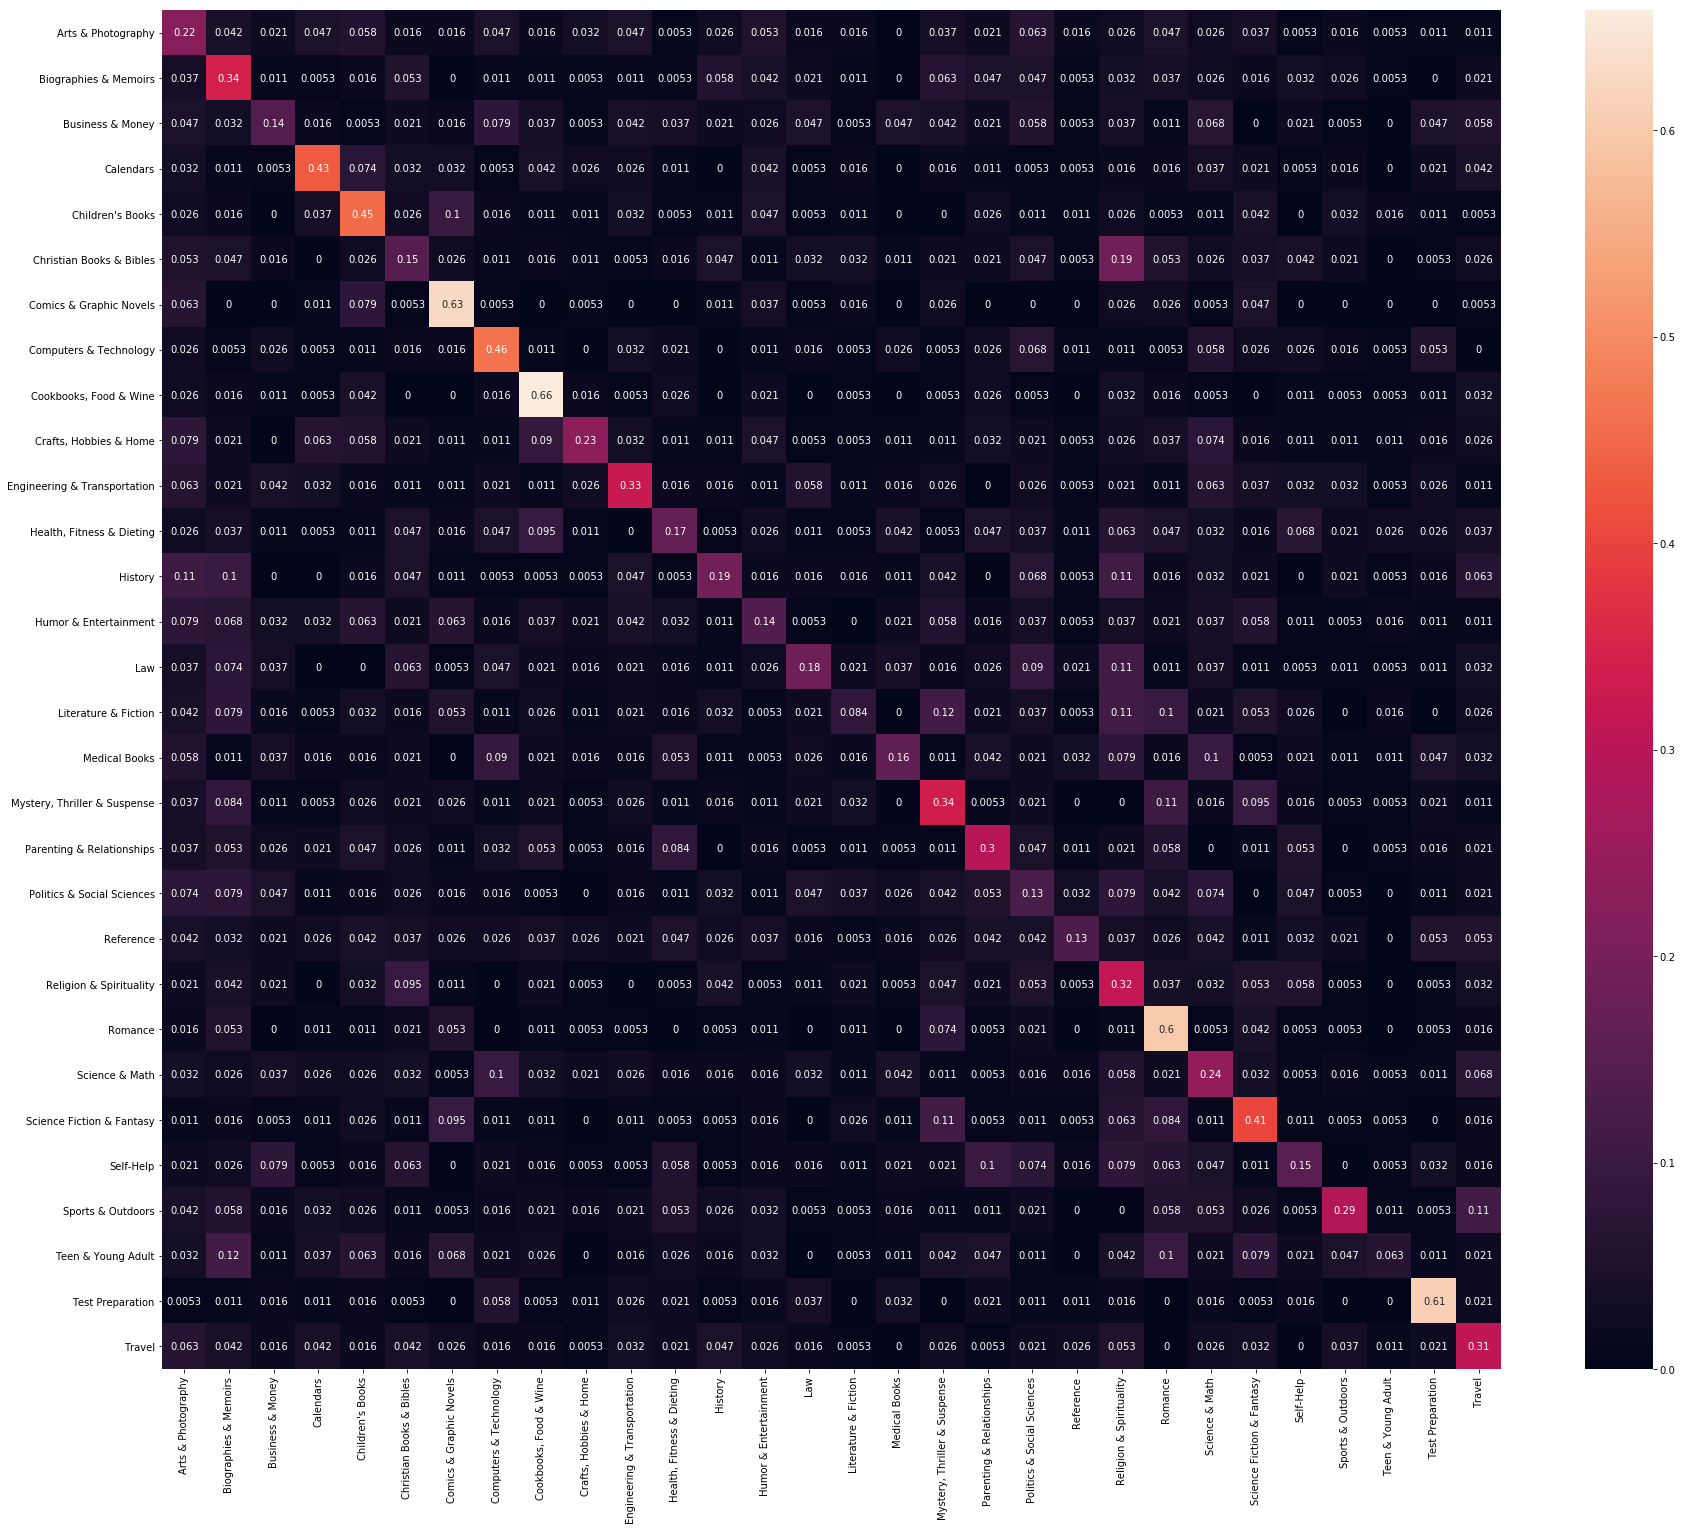

In [7]:
test()